<a href="https://colab.research.google.com/github/0seoyeon/tobigs-21st/blob/%EA%B3%B5%EC%84%9C%EC%97%B0/Week9/Generative%20Basic/%EA%B3%B5%EC%84%9C%EC%97%B0/Tobigs_Week9_GenBasic(20240313).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Basic Assignment (2024/03/13)
#### Questions(1,2) are below
#### Contact -> toa2413@naver.com / 송인혁(투빅스20기)

In [1]:
import datetime
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="../data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root="../data", train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 52177239.25it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1680946.02it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 11824361.02it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11359885.97it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Q1. Encoder/Decoder Implementation
    Show me your visualizations(MNIST images) using a VAE model made up of your own 'Encoder2/Decoder2'
    I can see your visualizations at the last part of this code file (Assignment 1 ; Visualization)
    
***You can refer to the examples right under this markdown, please make your own Encoder (Class name; Encoder2/Decoder2)***

In [3]:
# You can freely choose one of architectures you want that looks promising
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim2, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim2)
        self.mean = nn.Linear(hidden_dim2, latent_dim)
        self.var = nn.Linear (hidden_dim2, latent_dim) # 잠재 변수의 로그 분산을 계산 (로그 변환 -> 분산이 항상 양수임을 보장하고 수치적 안정성을 향상)

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        h_ = self.LeakyReLU(self.input1(x))
        h_ = self.LeakyReLU(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)
        return mean, log_var

In [26]:
class Encoder2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        super(Encoder2, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        self.mean = nn.Linear(hidden_dim2, latent_dim)
        self.var = nn.Linear (hidden_dim2, latent_dim)
        self.training = True

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)

        mean = self.mean(x)
        log_var = self.var(x)
        return mean, log_var

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, hidden_dim2, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim2)
        self.hidden2 = nn.Linear(hidden_dim2, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.hidden1(x))
        h = self.LeakyReLU(self.hidden2(h))
        x_hat = torch.sigmoid(self.output(h))
        return x_hat

In [27]:
class Decoder2(nn.Module):
    def __init__(self, latent_dim, hidden_dim2, hidden_dim1, output_dim):
        super(Decoder2, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        self.fc3 = nn.Linear(hidden_dim1, output_dim)

        self.sigmoid = nn.Sigmoid()  # Assuming the output needs to be between 0 and 1

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)  # Sigmoid to ensure output is between 0 and 1
        return x


In [28]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    # Think about why you need reparameterization trick (Hint; backpropagation)
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [41]:
# Any modifications are allowed depending on your own Encoder2/Decoder2
# -----------------------------------
x_dim  = 784
hidden_dim = 400
hidden_dim2 = 200
latent_dim = 20
epochs = 30
batch_size = 100
# -----------------------------------
input_dim = 784
hidden_dim1 = 16
hidden_dim2 = 32
latent_dim = 20
epochs = 30
bach_size = 100
output_dim = 784

# encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, hidden_dim2=hidden_dim2, latent_dim=latent_dim)
encoder = Encoder2(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, latent_dim=latent_dim)

# decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, hidden_dim2=hidden_dim2, output_dim = x_dim)
decoder = Decoder2(latent_dim=latent_dim, hidden_dim2 = hidden_dim2, hidden_dim1=hidden_dim1, output_dim = output_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

### Q2. (Optional Assignment)
    Refering to Beta-VAE(https://openreview.net/forum?id=Sy2fzU9gl), give any kind of manipulations on pre-made loss function, and visualize your samples.
    It would be nice to see whether the fidelity of sample data is improved or not! Also guess why.
***Warning)  you don't have to take all the contents of this paper! Look carefully at the Equation (4)***

In [42]:
# (Optional Assignment)
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # Think about how to calculate KLDivergence in closed form (Hint; assumptions for Gaussian), please refer to the following links
    # https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [43]:
def train(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        BCE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = BCE + KLD

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(x)))

    print("======> Epoch: {} Average loss: {:.4f}".format(
        epoch, train_loss / len(train_loader.dataset)))

In [44]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)
            x_hat, mean, log_var = model(x)
            BCE, KLD = loss_function(x, x_hat, mean, log_var)
            loss = BCE + KLD

            test_loss += loss.item()

            if batch_idx == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
                grid = torchvision.utils.make_grid(comparison.cpu())

In [45]:
# Trackning the process
# If you have difficulty on installing 'tqdm', modifications are allowed. Not necessary
from tqdm.auto import tqdm

# Training an VAE model, and record losses
for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
    print("\n")


  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	 Loss: 547.369453
Train Epoch: 0 [10000/60000 (17%)]	 Loss: 241.984082
Train Epoch: 0 [20000/60000 (33%)]	 Loss: 220.568047
Train Epoch: 0 [30000/60000 (50%)]	 Loss: 215.851992
Train Epoch: 0 [40000/60000 (67%)]	 Loss: 204.662109
Train Epoch: 0 [50000/60000 (83%)]	 Loss: 206.063105
======> Epoch: 0 Average loss: 245.2641


Train Epoch: 1 [0/60000 (0%)]	 Loss: 205.896250
Train Epoch: 1 [10000/60000 (17%)]	 Loss: 206.433047
Train Epoch: 1 [20000/60000 (33%)]	 Loss: 198.961934
Train Epoch: 1 [30000/60000 (50%)]	 Loss: 199.339434
Train Epoch: 1 [40000/60000 (67%)]	 Loss: 203.767441
Train Epoch: 1 [50000/60000 (83%)]	 Loss: 196.240254
======> Epoch: 1 Average loss: 201.1741


Train Epoch: 2 [0/60000 (0%)]	 Loss: 203.790059
Train Epoch: 2 [10000/60000 (17%)]	 Loss: 195.101289
Train Epoch: 2 [20000/60000 (33%)]	 Loss: 201.210469
Train Epoch: 2 [30000/60000 (50%)]	 Loss: 195.179121
Train Epoch: 2 [40000/60000 (67%)]	 Loss: 200.834883
Train Epoch: 2 [50000/60000 (8

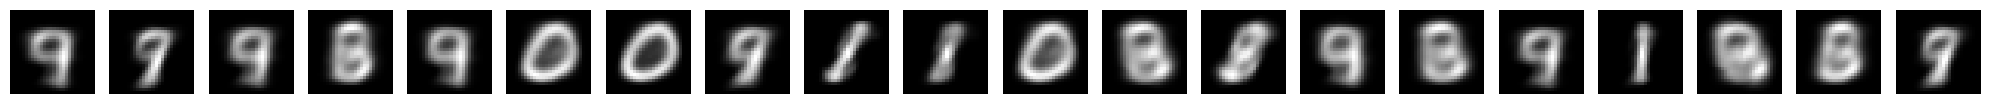

In [46]:
# After training decoder, begin visualize what comes after decoder given input z
def visualize(decoder,z):
    x_sample = decoder(z).view(20,28,28).detach().numpy()
    fig, axes = plt.subplots(nrows=1, ncols=20, figsize=(20, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(x_sample[i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

z_sample = torch.randn(20,20)

# (Assignment 1 ; Visualization)
visualize(decoder,z_sample)


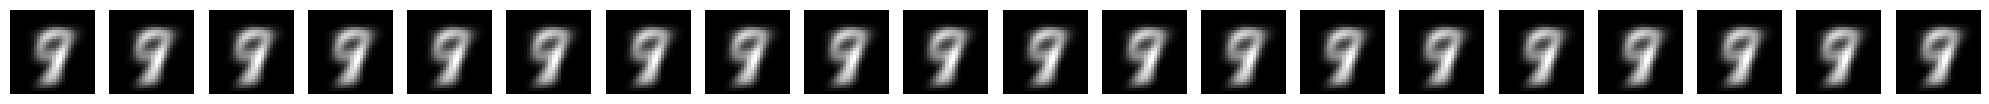

In [47]:
# Set seed numbers to take reproducibility
seed = 3
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
np.random.seed(seed)

# Random z
z = torch.randn(20)
# Make copies
z = z.repeat(20,1)

# Interpolation in latent space z
for i in range(20):
    z[i, 0] += i * 0.5 - (20 - 1) * 0.5 / 2

# (Assignment 1 ; Visualization)
visualize(decoder,z)

## Answer(Q2; Optional) : Please write any codes or statements below this space


In [48]:
# (Optional Assignment)
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # Think about how to calculate KLDivergence in closed form (Hint; assumptions for Gaussian), please refer to the following links
    # https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    Beta = 3
    return reproduction_loss, Beta*KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [49]:
def train(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        BCE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = BCE + KLD

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(x)))

    print("======> Epoch: {} Average loss: {:.4f}".format(
        epoch, train_loss / len(train_loader.dataset)))

In [50]:
# Trackning the process
# If you have difficulty on installing 'tqdm', modifications are allowed. Not necessary
from tqdm.auto import tqdm

# Training an VAE model, and record losses
for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
    print("\n")


  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	 Loss: 185.883242
Train Epoch: 0 [10000/60000 (17%)]	 Loss: 184.630410
Train Epoch: 0 [20000/60000 (33%)]	 Loss: 182.566563
Train Epoch: 0 [30000/60000 (50%)]	 Loss: 172.913867
Train Epoch: 0 [40000/60000 (67%)]	 Loss: 197.035293
Train Epoch: 0 [50000/60000 (83%)]	 Loss: 189.095137
======> Epoch: 0 Average loss: 186.0437


Train Epoch: 1 [0/60000 (0%)]	 Loss: 189.141914
Train Epoch: 1 [10000/60000 (17%)]	 Loss: 188.235625
Train Epoch: 1 [20000/60000 (33%)]	 Loss: 192.980801
Train Epoch: 1 [30000/60000 (50%)]	 Loss: 185.457168
Train Epoch: 1 [40000/60000 (67%)]	 Loss: 185.513516
Train Epoch: 1 [50000/60000 (83%)]	 Loss: 185.725156
======> Epoch: 1 Average loss: 185.6631


Train Epoch: 2 [0/60000 (0%)]	 Loss: 182.715313
Train Epoch: 2 [10000/60000 (17%)]	 Loss: 179.972617
Train Epoch: 2 [20000/60000 (33%)]	 Loss: 180.705352
Train Epoch: 2 [30000/60000 (50%)]	 Loss: 187.760195
Train Epoch: 2 [40000/60000 (67%)]	 Loss: 188.713613
Train Epoch: 2 [50000/60000 (8

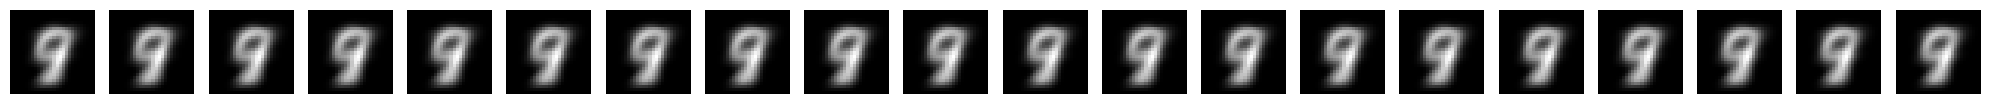

In [51]:
# Set seed numbers to take reproducibility
seed = 3
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
np.random.seed(seed)

# Random z
z = torch.randn(20)
# Make copies
z = z.repeat(20,1)

# Interpolation in latent space z
for i in range(20):
    z[i, 0] += i * 0.5 - (20 - 1) * 0.5 / 2

# (Assignment 1 ; Visualization)
visualize(decoder,z)

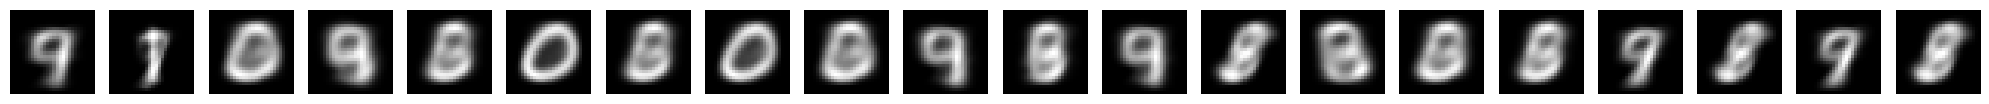

In [52]:
# After training decoder, begin visualize what comes after decoder given input z
def visualize(decoder,z):
    x_sample = decoder(z).view(20,28,28).detach().numpy()
    fig, axes = plt.subplots(nrows=1, ncols=20, figsize=(20, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(x_sample[i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

z_sample = torch.randn(20,20)

# (Assignment 1 ; Visualization)
visualize(decoder,z_sample)

loss function에서의 KL Divergence term에 가중치 Beta를 곱해준 BVAE (Beta=3)와 가중치를 따로 설정하지 않은 (Beta=1) VAE로 생성한 이미지를 비교한 결과, 눈에 띄는 차이가 보이지는 않았다. epoch 수를 늘려 학습을 충분히 진행하거나, Beta값을 유의미한 다른 값으로 설정해주면 차이가 발생할 수도 있을 것이라고 추측해 볼 수 있겠다.

[개인 기록용] 이 파일에는 포함시키지 않았지만 인코더와 디코더 네크워크의 hidden layer를 하나 더 추가하고, hidden dimension 차원을 늘린 (400, 200, 100) VAE의 결과는 숫자로 보이지 않을만큼 noisy했다. 이런 성능의 저하가 신경망의 depth 문제인지, 은닉층의 차원 문제인지, 확실치 않아서 추후 확인이 필요하다.